# Interseismic practical

## Written for the COMET InSAR Workshop 2021.

For meeting with Richard:
- install seaborn

In [1]:
# Import required modules. Run this before continuing.
%matplotlib inline

import subprocess as subp
import numpy as np
from scipy import interpolate
#import seaborn as sns
import interseis_lib as lib
import matplotlib.pyplot as plt
import importlib

importlib.reload(lib)

<module 'interseis_lib' from '/storage/earth_data/home/eearw/Interseismic_practical/interseis_lib.py'>

## 1. Introduction

Geodesists commonly consider steady slip on a screw dislocation embedded within an elastic half-space to model interseismic deformation (Savage and Burford, 1973, Wright et al., 2013). In this model, the surface velocities, v, are a simple function of the distance from the fault, x, the slip rate, s, and the locking depth, d:

\begin{equation}
\normalsize v = \frac{s}{\pi}tan^{-1}\left(\frac{x}{d}\right) \qquad \qquad (1)
\end{equation} 

Yesterday, you generated a time-series over the NAF using LiCSBAS.
In asc.h5 you'll find the velocities for another frame over the NAF.
We will use both of these frames to estimate the parameters in Equation 1.

## 2. Load the input time-series

In [2]:
# setup file names
vel_file_asc = 'data/087A_04904_121313_vel'
par_file_asc = 'data/087A_04904_121313.par'
E_file_asc = 'data/087A_04904_121313_E.geo'
N_file_asc = 'data/087A_04904_121313_N.geo'
U_file_asc = 'data/087A_04904_121313_U.geo'

vel_file_desc = 'data/167D_04884_131212_vel'
par_file_desc = 'data/167D_04884_131212.par'
E_file_desc = 'data/167D_04884_131212_E.geo'
N_file_desc = 'data/167D_04884_131212_N.geo'
U_file_desc = 'data/167D_04884_131212_U.geo'

# read array dimensions from par file
width_asc = int(lib.get_par(par_file_asc,'width'))
length_asc = int(lib.get_par(par_file_asc,'nlines'))

width_desc = int(lib.get_par(par_file_desc,'width'))
length_desc = int(lib.get_par(par_file_desc,'nlines'))

# get corner positions
corner_lat_asc = float(lib.get_par(par_file_asc,'corner_lat'))
corner_lon_asc = float(lib.get_par(par_file_asc,'corner_lon'))

corner_lat_desc = float(lib.get_par(par_file_desc,'corner_lat'))
corner_lon_desc = float(lib.get_par(par_file_desc,'corner_lon'))

# get post spacing
post_lat_asc = float(lib.get_par(par_file_asc,'post_lat'))
post_lon_asc = float(lib.get_par(par_file_asc,'post_lon'))

post_lat_desc = float(lib.get_par(par_file_desc,'post_lat'))
post_lon_desc = float(lib.get_par(par_file_desc,'post_lon'))

# calculate grid spacings
lat_asc = corner_lat_asc + post_lat_asc*np.arange(1,length_asc+1) - post_lat_asc/2
lon_asc = corner_lon_asc + post_lon_asc*np.arange(1,width_asc+1) - post_lon_asc/2

lat_desc = corner_lat_desc + post_lat_desc*np.arange(1,length_desc+1) - post_lat_desc/2
lon_desc = corner_lon_desc + post_lon_desc*np.arange(1,width_desc+1) - post_lon_desc/2

# load in velocities
vel_asc = np.fromfile(vel_file_asc, dtype='float32').reshape((length_asc, width_asc))
vel_desc = np.fromfile(vel_file_desc, dtype='float32').reshape((length_desc, width_desc))

# load in unit vectors
E_asc = np.fromfile(E_file_asc, dtype='float32').reshape((length_asc, width_asc))
N_asc = np.fromfile(N_file_asc, dtype='float32').reshape((length_asc, width_asc))
U_asc = np.fromfile(U_file_asc, dtype='float32').reshape((length_asc, width_asc))

E_desc = np.fromfile(E_file_desc, dtype='float32').reshape((length_desc, width_desc))
N_desc = np.fromfile(N_file_desc, dtype='float32').reshape((length_desc, width_desc))
U_desc = np.fromfile(U_file_desc, dtype='float32').reshape((length_desc, width_desc))

# load the naf fault trace
fault_trace = np.loadtxt('data/naf_trace.xy')

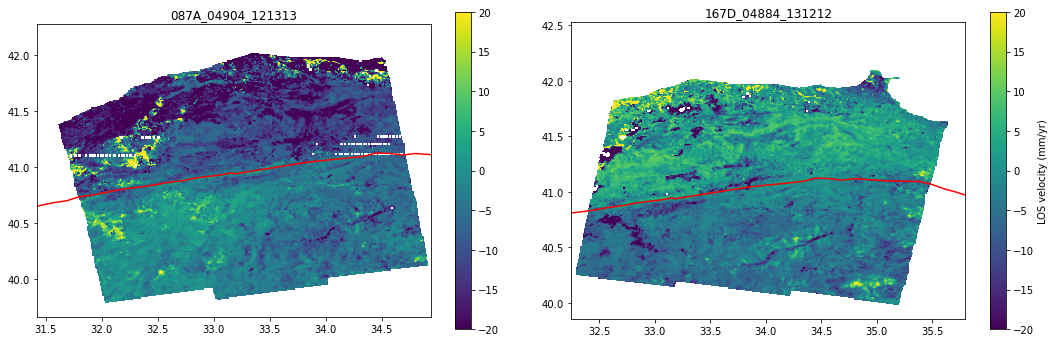

In [3]:
# plot input vels
fig, axs = plt.subplots(1,2,figsize=(15,5))
plt.tight_layout()

im = axs[0].imshow(vel_asc, extent=[np.amin(lon_asc), np.amax(lon_asc), np.amin(lat_asc), np.amax(lat_asc)], vmin=-20, vmax=20)
axs[0].plot(fault_trace[:,0], fault_trace[:,1], color="red")
plt.colorbar(im,ax=axs[0])
axs[0].set_title('087A_04904_121313')
axs[0].set_xlim(np.amin(lon_asc), np.amax(lon_asc))
axs[0].set_ylim(np.amin(lat_asc), np.amax(lat_asc))

im = axs[1].imshow(vel_desc, extent=[np.amin(lon_desc), np.amax(lon_desc), np.amin(lat_desc), np.amax(lat_desc)], vmin=-20, vmax=20)
axs[1].plot(fault_trace[:,0], fault_trace[:,1], color="red")
plt.colorbar(im, ax=axs[1], label="LOS velocity (mm/yr)")
axs[1].set_title('167D_04884_131212')
axs[1].set_xlim(np.amin(lon_desc), np.amax(lon_desc))
axs[1].set_ylim(np.amin(lat_desc), np.amax(lat_desc))

plt.show()

Lets try profiling the ascending velocities.

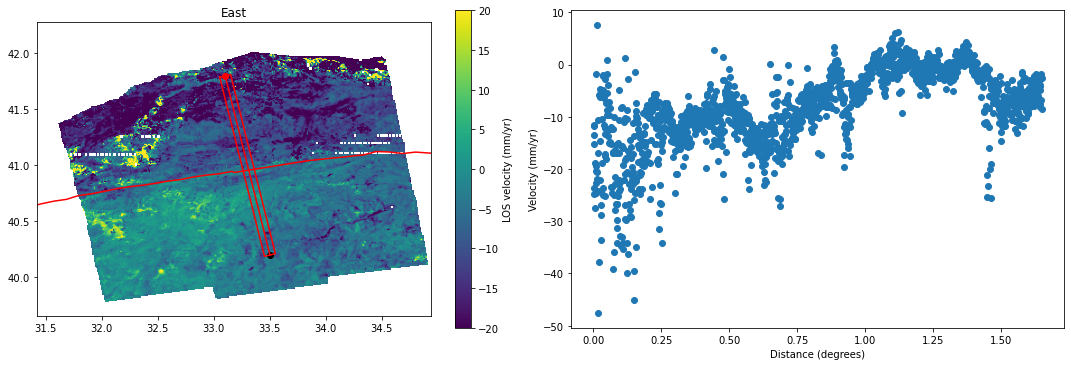

In [4]:
prof_start = (33.1, 41.8)
prof_end = (33.5, 40.2)

prof_params = {
    "nbins": 100, # number of bins to split the profile into
    "width": 0.1 # total width of the profile in degrees (1 degree ~ 110 km)
}

bin_val, prof_bin_mids, points_val, points_dist, points_poly \
    = lib.profile_data(lon_asc,lat_asc,vel_asc,prof_start,prof_end,prof_params)

fig, axs = plt.subplots(1,2,figsize=(15,5))
plt.tight_layout()

im = axs[0].imshow(vel_asc, extent=[np.amin(lon_asc), np.amax(lon_asc), np.amin(lat_asc), np.amax(lat_asc)], vmin=-20, vmax=20)
axs[0].plot(fault_trace[:,0], fault_trace[:,1], color="red")
axs[0].plot([prof_start[0], prof_end[0]], [prof_start[1], prof_end[1]], color="red")
axs[0].plot(points_poly[:,0],points_poly[:,1], color="red")
axs[0].scatter(prof_start[0],prof_start[1], color='red')
axs[0].scatter(prof_end[0],prof_end[1], color='black')
plt.colorbar(im, ax=axs[0], label="LOS velocity (mm/yr)")
axs[0].set_title('East')
axs[0].set_xlim(np.amin(lon_asc), np.amax(lon_asc))
axs[0].set_ylim(np.amin(lat_asc), np.amax(lat_asc))

axs[1].scatter(points_dist,points_val)
axs[1].set_xlabel("Distance (degrees)")
axs[1].set_ylabel("Velocity (mm/yr)")

plt.show()

## 3. Decompose the line-of-sight velocities into East and Vertical

We will make the assumption of zero North-South motion so that we can decompose our two line-of-sight velocity maps (ascending and descending) into East and Vertical motion.

\begin{equation}
    \begin{bmatrix} V_{asc} \\ V_{desc} \end{bmatrix} = \begin{bmatrix} -cos(\theta_{asc}) & sin(\theta_{asc})cos(\alpha_{asc}) \\ -cos(\theta_{desc}) & sin(\theta_{desc})cos(\alpha_{desc}) \end{bmatrix} \begin{bmatrix} V_U \\ V_E \end{bmatrix}
\end{equation}

where $V_{asc}$ and $V_{desc}$ are the LOS velocities, $\theta$ is the radar incidence angle, and $\alpha$ is the azimuth of the along-track satellite heading.

Currently, these velocities are on two different grids. We need to unify the grids so that we can perform the velocity decomposition.

In [5]:
# limits and intervals for new grid
lon_min = np.amin([lon_asc[0], lon_desc[0]])
lon_max = np.amax([lon_asc[-1], lon_desc[-1]])
lon_int = np.amin([post_lon_asc, post_lon_desc])
lon_regrid = np.arange(lon_min,lon_max+lon_int,lon_int)

lat_max = np.amax([lat_asc[0], lat_desc[0]])
lat_min = np.amin([lat_asc[-1], lat_desc[-1]])
lat_int = np.absolute(np.amin([post_lat_asc, post_lat_desc]))
lat_regrid = np.arange(lat_min,lat_max+lat_int,lat_int)

xx_regrid, yy_regrid = np.meshgrid(lon_regrid, lat_regrid[::-1])
coords_regrid = np.transpose(np.vstack((xx_regrid.flatten(),yy_regrid.flatten())))

# interpolate velocities onto this new grid
xx_asc, yy_asc = np.meshgrid(lon_asc, lat_asc)
vel_asc_regrid = interpolate.griddata((xx_asc.ravel(), yy_asc.ravel()), vel_asc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel()))
vel_asc_regrid = vel_asc_regrid.reshape((len(lat_regrid),len(lon_regrid)))

xx_desc, yy_desc = np.meshgrid(lon_desc, lat_desc)
vel_desc_regrid = interpolate.griddata((xx_desc.ravel(), yy_desc.ravel()), vel_desc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel()))
vel_desc_regrid = vel_desc_regrid.reshape((len(lat_regrid),len(lon_regrid)))

# interpolate the component vectors into the new grid
E_asc_regrid = interpolate.griddata((xx_asc.ravel(), yy_asc.ravel()), E_asc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))
N_asc_regrid = interpolate.griddata((xx_asc.ravel(), yy_asc.ravel()), N_asc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))
U_asc_regrid = interpolate.griddata((xx_asc.ravel(), yy_asc.ravel()), U_asc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))

E_desc_regrid = interpolate.griddata((xx_desc.ravel(), yy_desc.ravel()), E_desc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))
N_desc_regrid = interpolate.griddata((xx_desc.ravel(), yy_desc.ravel()), N_desc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))
U_desc_regrid = interpolate.griddata((xx_desc.ravel(), yy_desc.ravel()), U_desc.ravel(), (xx_regrid.ravel(), yy_regrid.ravel())).reshape((len(lat_regrid),len(lon_regrid)))


Currently the two velocities fields are relative to their own reference pixels. We need to make this reference the same so that the velocities can be decomposed correctly.

In [6]:
'''
# define new reference area
ref = [33.5, 40.7]

# get index
ind_lon = np.argmin(np.absolute(lon_regrid-ref[0]))
ind_lat = np.argmin(np.absolute(lat_regrid-ref[1]))

# set as new reference
vel_asc_regrid = vel_asc_regrid - vel_asc_regrid[ind_lat,ind_lon]
vel_desc_regrid = vel_desc_regrid - vel_desc_regrid[ind_lat,ind_lon]
'''

'\n# define new reference area\nref = [33.5, 40.7]\n\n# get index\nind_lon = np.argmin(np.absolute(lon_regrid-ref[0]))\nind_lat = np.argmin(np.absolute(lat_regrid-ref[1]))\n\n# set as new reference\nvel_asc_regrid = vel_asc_regrid - vel_asc_regrid[ind_lat,ind_lon]\nvel_desc_regrid = vel_desc_regrid - vel_desc_regrid[ind_lat,ind_lon]\n'

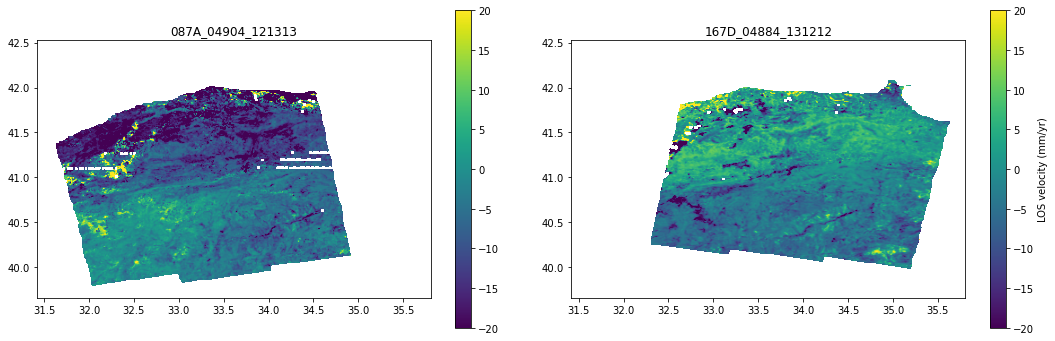

In [7]:
# plot the regridded velocities to make sure they're fine
fig, axs = plt.subplots(1,2,figsize=(15,5))
plt.tight_layout()

im = axs[0].imshow(vel_asc_regrid, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], vmin=-20, vmax=20)
plt.colorbar(im,ax=axs[0])
axs[0].set_title('087A_04904_121313')

im = axs[1].imshow(vel_desc_regrid, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], vmin=-20, vmax=20)
plt.colorbar(im, ax=axs[1], label="LOS velocity (mm/yr)")
axs[1].set_title('167D_04884_131212')

plt.show()

Now we'll run the decomposition for each pixel, assuming no correlation between pixels.

In [8]:
# pre-allocate
vel_E = np.zeros((len(lat_regrid), len(lon_regrid)))
vel_U = np.zeros((len(lat_regrid), len(lon_regrid)))

# loop through every pixel
for ii in np.arange(0,len(lat_regrid)):
    for jj in np.arange(0,len(lon_regrid)):
        
        # create the design matrix
        G = np.array([[U_asc_regrid[ii,jj], E_asc_regrid[ii,jj]], [U_desc_regrid[ii,jj], E_desc_regrid[ii,jj]]])
        
        # get the two velocities for this pixel
        d = np.array([[vel_asc_regrid[ii,jj], vel_desc_regrid[ii,jj]]]).T
        
        # solve the linear system for the Up and East velocities
        m = np.linalg.solve(G, d)
        
        # save to arrays
        vel_U[ii,jj] = m[0]
        vel_E[ii,jj] = m[1]
        

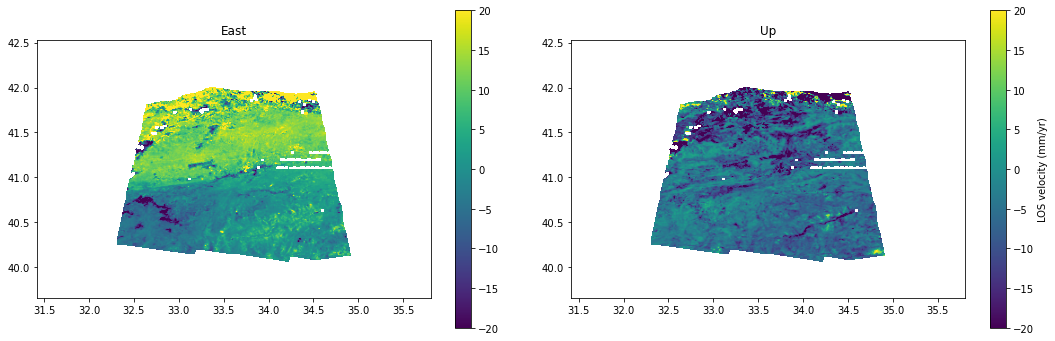

In [9]:
# plot the results
fig, axs = plt.subplots(1,2,figsize=(15,5))
plt.tight_layout()

im = axs[0].imshow(vel_E, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], vmin=-20, vmax=20)
plt.colorbar(im,ax=axs[0])
axs[0].set_title('East')

im = axs[1].imshow(vel_U, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], vmin=-20, vmax=20)
plt.colorbar(im, ax=axs[1], label="LOS velocity (mm/yr)")
axs[1].set_title('Up')

plt.show()

## 4. Profile the East-West velocities

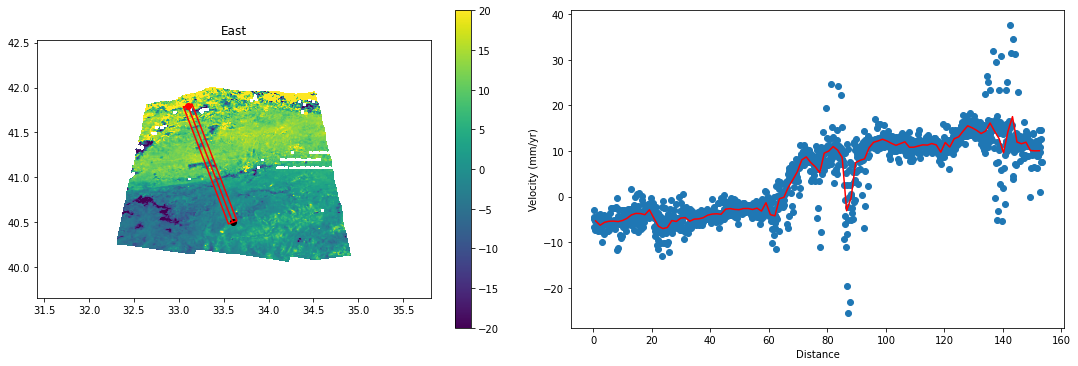

In [10]:
importlib.reload(lib)
# Profile east velocities
prof_start = (33.1, 41.8)
prof_end = (33.6, 40.5)

prof_params = {
    "nbins": 100, # number of bins to split the profile into
    "width": 0.1 # total width of the profile in degrees (1 degree ~ 110 km)
}

bin_val, prof_bin_mids, points_val, points_dist, points_poly \
    = lib.profile_data(lon_regrid,lat_regrid,vel_E,prof_start,prof_end,prof_params)

# rough conversion from degrees to km
points_dist = points_dist * 110
prof_bin_mids = prof_bin_mids * 110

fig, axs = plt.subplots(1,2,figsize=(15,5))
plt.tight_layout()

im = axs[0].imshow(vel_E, extent=[lon_regrid[0], lon_regrid[-1], lat_regrid[0], lat_regrid[-1]], vmin=-20, vmax=20)
axs[0].plot([prof_start[0], prof_end[0]], [prof_start[1], prof_end[1]], color="red")
axs[0].plot(points_poly[:,0],points_poly[:,1], color="red")
axs[0].scatter(prof_start[0],prof_start[1], color='red')
axs[0].scatter(prof_end[0],prof_end[1], color='black')
plt.colorbar(im,ax=axs[0])
axs[0].set_title('East')

axs[1].scatter(points_dist,points_val)
axs[1].plot(prof_bin_mids,bin_val,color="red")
axs[1].set_xlabel("Distance")
axs[1].set_ylabel("Velocity (mm/yr)")

plt.show()

In [11]:
'''
# For now, load interseis vels from txt file
interseis = np.loadtxt('interseis.txt', delimiter=',')

# Plot
fig = plt.figure(figsize=(10, 10))
plt.errorbar(interseis[:,0], interseis[:,1], interseis[:,2], fmt='o')
plt.xlabel('Fault-perp distance (km)')
plt.ylabel('Fault-parallel velocity (mm/yr)')
plt.show()
'''

"\n# For now, load interseis vels from txt file\ninterseis = np.loadtxt('interseis.txt', delimiter=',')\n\n# Plot\nfig = plt.figure(figsize=(10, 10))\nplt.errorbar(interseis[:,0], interseis[:,1], interseis[:,2], fmt='o')\nplt.xlabel('Fault-perp distance (km)')\nplt.ylabel('Fault-parallel velocity (mm/yr)')\nplt.show()\n"

## 5. Forward model

We'll begin with a simple forward model to get a ballpark estimate of the slip and locking depth.

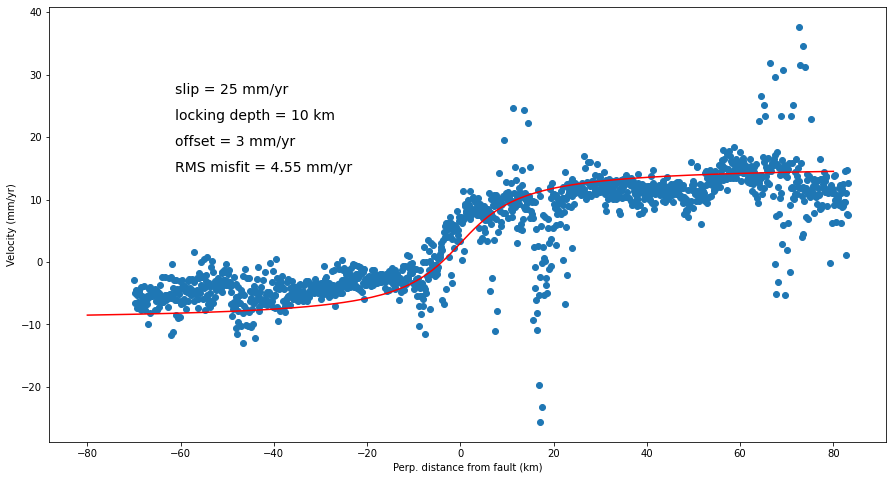

In [12]:
# shift profile so thast fault is at 0 km
x_prof = points_dist - 70

# Vector of positions every 1 km for -100 km to 100 km
x = np.arange(-80,81,1)

# Slip and locking depth
s = 25 # mm/yr
d = 10 # km
c = 3 # mm/yr

# run forward model
v = lib.screw_disc(x, s, d, c)

# calculate rms misfit
v_forward = lib.screw_disc(x_prof, s, d, c)
rms_forward = lib.rms_misfit(points_val,v_forward)

# Plot comparison
fig, axs = plt.subplots(1,1,figsize=(15,8))

plt.scatter(x_prof,points_val)
plt.plot(x, v, c='r')

plt.text(0.15, 0.8, 'slip = ' + str(s) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.74, 'locking depth = ' + str(d) + ' km', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.68, 'offset = ' + str(c) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.62, 'RMS misfit = ' + str(round(rms_forward,2)) + ' mm/yr', fontsize=14, transform = axs.transAxes)

plt.xlabel('Perp. distance from fault (km)')
plt.ylabel('Velocity (mm/yr)')

plt.show()

## 6. Bayesian inversion

Bayesian inversions take some prior knowledge about the model, and through some solver, estimate the posteriori probability distribution.
This gives us uncertainties on our parameter estimates.

We establish the following priors:
- $s$ is uniformaly distributed between [0,40] mm/yr
- $d$ is uniformaly distributed between [1,50] km
- $c$ is uniformaly distributed between [-5,5] mm/yr

Our loglikelihood function:
\begin{equation}
    \sum -0.5*(d-g(m))*W*(d-g(m))
\end{equation}

Our logprior just checks that the value is within the provided ranges.

In [13]:
importlib.reload(lib)

# from profile
x_prof = points_dist - 70
v_prof = points_val

# model params
m_start = np.array([10, 10, 0]) # slip in mm/yr, locking depth in km
m_min = np.array([0, 1, -5])
m_max = np.array([40, 50, 5])
vcm = np.eye(len(x_prof)) / 1000000
W = np.linalg.inv(vcm)

# unit conversion
x = x_prof * 1000
v = v_prof / 1000

# inversion setup
n_iterations = 10000
burn_in = round(n_iterations/5)
#np.random.seed(seed=11)
models_saved=np.zeros((n_iterations,len(m_start)))
ll_saved=np.zeros((n_iterations,1))
n_accept = 0 # number of accepted models
n_reject = 0 # number of rejected models

#print(lib.loglike(x, v, np.array([40,30,-1]), W))

# starting model
m_current = m_start.copy()

# run inversion
for ii in range(n_iterations):
    
    # propose model
    m_trial = m_current.copy()
    m_trial = m_trial + np.random.uniform(low=-5,high=5,size=len(m_trial))
    
    # check limits
    if not(lib.logprior(m_trial,m_min,m_max)):
        n_reject += 1
        models_saved[ii,:] = m_current
        continue
    
    # calculate likelihood
    ll_current = lib.loglike(x, v, m_current, W)
    ll_trial = lib.loglike(x, v, m_trial, W)
    
    # if fit improved
    #if np.exp(ll_trial-ll_current) > np.random.uniform(low=0, high=1,size=1):
    #if np.exp(ll_current-ll_trial) > np.random.uniform(low=0, high=1,size=1):
    if (ll_trial < ll_current) or (np.random.uniform(low=0, high=1,size=1) > 0.75):
        m_current = m_trial
        ll_current = ll_trial
        n_accept += 1
    else:
        n_reject += 1
    models_saved[ii,:] = m_current
    ll_saved[ii] = ll_current
    
# find best fit model using min of likelihood function
best_model = models_saved[np.argmin(ll_saved[ll_saved!=0]),:]

First, we'll plot the accepted trial models to see how the algorithm explores the parameter space.
We'll show the first 20% of iterations in red and the rest in blue.
These early iterations are often termed a "burn-in" period.

Text(0, 0.5, 'Locking depth (km)')

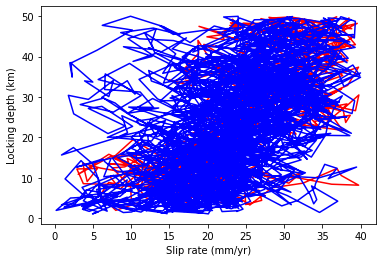

In [14]:
# plot walker 
plt.figure()
plt.plot(models_saved[:burn_in,0],models_saved[:burn_in,1],'r')
plt.plot(models_saved[burn_in:,0],models_saved[burn_in:,1],'b')
plt.xlabel('Slip rate (mm/yr)')
plt.ylabel('Locking depth (km)')

If the starting model is significantly far from the best fit model, we should see the model move through the parameter towards a minimum.
We are also likely to see a trade-off between slip rate and locking depth, with an increase in one correlating with an increase in the other.

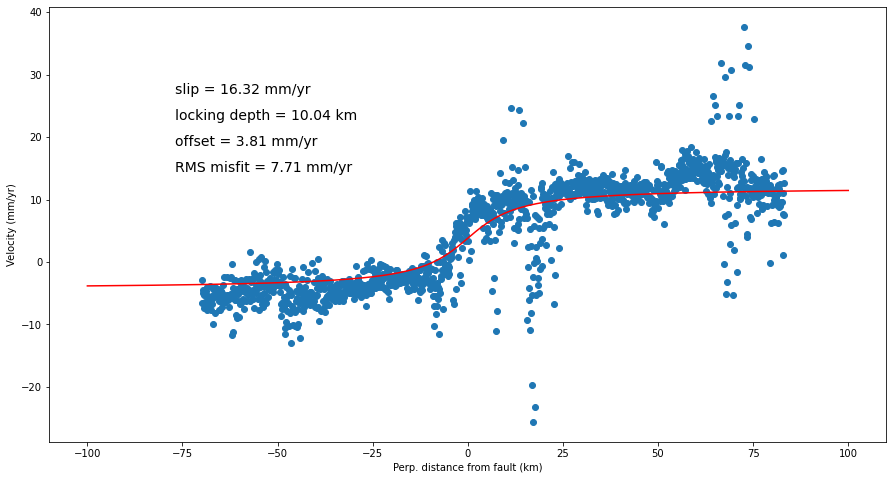

In [15]:
# calculate rms misfit
v_final = lib.screw_disc(x_prof, best_model[0], best_model[1], best_model[2])
best_rms = lib.rms_misfit(v,v_final)

# for plotting
x = np.arange(-100,101,1)
v_final_plot = lib.screw_disc(x, best_model[0], best_model[1], best_model[2])

# Plot comparison
fig, axs = plt.subplots(1,1,figsize=(15,8))

plt.scatter(x_prof,v_prof)
plt.plot(x, v_final_plot, c='r')

plt.text(0.15, 0.8, 'slip = ' + str(round(best_model[0],2)) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.74, 'locking depth = ' + str(round(best_model[1],2)) + ' km', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.68, 'offset = ' + str(round(best_model[2],2)) + ' mm/yr', fontsize=14, transform = axs.transAxes)
plt.text(0.15, 0.62, 'RMS misfit = ' + str(round(best_rms,2)) + ' mm/yr', fontsize=14, transform = axs.transAxes)

plt.xlabel('Perp. distance from fault (km)')
plt.ylabel('Velocity (mm/yr)')

plt.show()

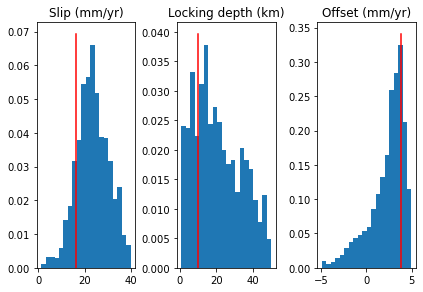

In [16]:
# histograms
fig, axs = plt.subplots(1,3)
plt.tight_layout()
burn_in = 5000

# plot histograms
axs[0].hist(models_saved[burn_in:,0], bins=20, density=True)
axs[1].hist(models_saved[burn_in:,1], bins=20, density=True)
axs[2].hist(models_saved[burn_in:,2], bins=20, density=True)

# plot best model values
axs[0].plot([best_model[0], best_model[0]],[0, axs[0].get_ylim()[1]], color="red")
axs[1].plot([best_model[1], best_model[1]],[0, axs[1].get_ylim()[1]], color="red")
axs[2].plot([best_model[2], best_model[2]],[0, axs[2].get_ylim()[1]], color="red")

axs[0].set_title('Slip (mm/yr)')
axs[1].set_title('Locking depth (km)')
axs[2].set_title('Offset (mm/yr)')

plt.show()

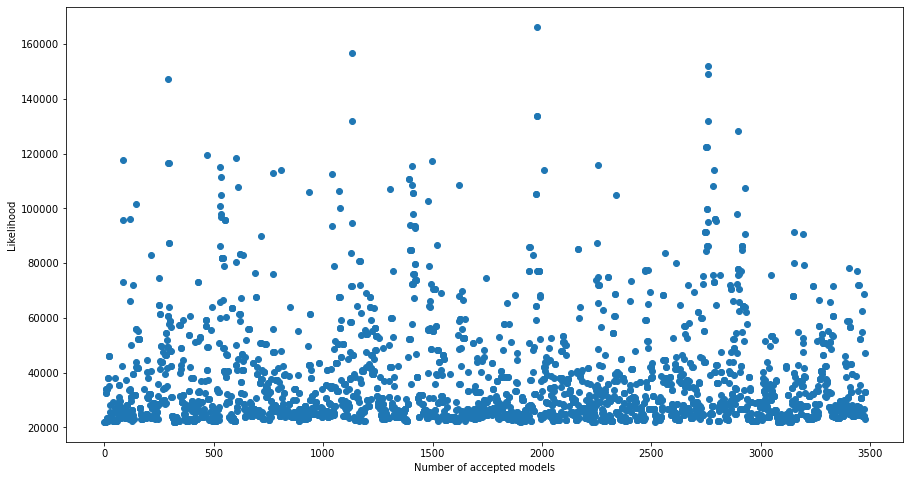

In [17]:
# ll through run

# remove burn in
ll_saved_trim = ll_saved[burn_in:]

# need to remove zeros first
ll_saved_trim = ll_saved_trim[ll_saved_trim != 0]

fig, axs = plt.subplots(1,1,figsize=(15,8))

axs.scatter(np.arange(1,len(ll_saved_trim)+1),ll_saved_trim)
axs.set_xlabel('Number of accepted models')
axs.set_ylabel('Likelihood')

#axs[1].scatter(np.arange(1,len(ll_saved)+1),np.log(ll_saved))
#axs[1].set_xlabel('Number of accepted models')
#axs[1].set_ylabel('Likelihood')
#axs[1].set_yscale("log")

plt.show()


In [18]:
# bivariate plot